#### Student Name: Mai Ngo
#### Course Name and Number: CSC 583 Natural Language Processing
#### Assignment 3 - Text Classification using RNNs and PyTorch
#### Date: 10/6/2024

1.   **Code help** -- Stack Overflow and W3Shools.
2.   **Development environment** -- Google Colab.
3.   **Heavily relied on:**
  
    *   **PyTorch website** -- https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html -- Understanding model code.
    *   **Google Colab** -- AI suggestive codes.
    *   **Google Gemini** -- Understanding skeleton code -- not to feel overwhelmed.











In [1]:
#Mount my Google Drive.
from google.colab import drive
drive.mount("/content/drive")
import os
directory = '/content/drive/My Drive/CSC583'
os.chdir(directory)

#Ensure the files are there (in the folder).
!pwd

Mounted at /content/drive
/content/drive/My Drive/CSC583


### **Check for GPU's**

In [2]:
import torch

#If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print ('There are %d GPU(s) available.' % torch.cuda.device_count())
    print ('We will use the GPU:', torch.cuda.get_device_name(0))
#If not...
else:
    print ('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### **Some Important Import's**

In [3]:
#Linear algebra.
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import string
import re
import statistics
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

## **(1) Load Datasets**

In [4]:
#Read tab-delimited file as pandas DataFrame, encoding UTF-8.
df_train = pd.read_csv('fakenews_train.tsv', delimiter='\t', encoding='utf-8')
df_test = pd.read_csv('fakenews_test.tsv', delimiter='\t', encoding='utf-8')

#----------------
print (df_train.shape)
print (df_test.shape)
df_train.tail()

(4447, 3)
(1112, 2)


,id,content,labels
4442,1864,Don’t forget to use N95 mask https://t.co/W5RP...,1
4443,772,President Trump congratulated Japanese Prime M...,1
4444,2454,BREAKING: CUNY announces student at @JohnJayCo...,1
4445,5710,CDC confirms Chinese coronavirus has arrived i...,1
4446,6334,Chinese Premier Li Keqiang arrives in #coronav...,1


### **Inspect some properties of the datasets**

In [5]:
#Check the class distribution (Fake/True; stratified) in train set.
def binaryRatio(df):
  '''Get fake news ratio of the the dataset.'''

  shape = df.shape
  fakecount = df[(df['labels'] == 0)].shape[0]  #Count of fake entries.
  print (f'Fake ratio: shape={df.shape} -- fake {fakecount}/{shape[0]} \
                                              = {fakecount/shape[0]}')

binaryRatio(df_train)

Fake ratio: shape=(4447, 3) -- fake 2945/4447                                               = 0.6622442095794918


In [6]:
#Sentence lengths for the train set.
#With simple white-space delimiter.
df_train['content_length'] = df_train['content'].apply(lambda x: len(x.split()))

#Mean and stdev of lengths.
lengths = df_train['content_length'].tolist()
print (f'Mean: {statistics.mean(lengths)}, Stdev: {statistics.stdev(lengths)},\
                                           Max: {max(lengths)}')

df_train.head()

Mean: 19.773105464357993, Stdev: 13.641496714680176,                                           Max: 140


,id,content,labels,content_length
0,466,"Coronavirus patients are being ""cremated alive...",0,8
1,1823,A video shows a creature on top of a dome-like...,0,22
2,4708,A video showing an anti-China protest amid the...,0,12
3,4740,Article suggests African skin and blood is res...,0,10
4,3294,The Brazilian Government is handling a 600 bra...,0,31


## **(2) Build vocabulary**

In [7]:
!pip install nltk

In [8]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
#Check NLTK's word_tokenize() function.
from nltk import word_tokenize

sent = "Congress has passed a US$8.3 billion coronavirus response bill, which includes $2.2 billion for the CDC to â€œprevent, prepare for, and respond to coronavirus, domestically or internationally.â€"
#"Text classification is a fundamental natural language processing (NLP) task."

tokens = word_tokenize(sent)
print (tokens)

['Congress', 'has', 'passed', 'a', 'US', '$', '8.3', 'billion', 'coronavirus', 'response', 'bill', ',', 'which', 'includes', '$', '2.2', 'billion', 'for', 'the', 'CDC', 'to', 'â€œprevent', ',', 'prepare', 'for', ',', 'and', 'respond', 'to', 'coronavirus', ',', 'domestically', 'or', 'internationally.â€\x9d']


In [10]:
def tokenize (text):
  '''Tokenize text. Returning  list of string.'''

  #First clean up the text by replacing non-ascii characters to a space.
  text = re.sub(r"[^\x00-\x7F]+", " ", text)

  #1.Text to lowercase.
  text = text.lower()

  #2.Remove punctuations.
  text = re.sub(r'[^\w\s]', ' ', text)

  #3.Remove numbers.
  text = re.sub(r"\d+", ' ', text)

  #4.Separate words has '-' or '_' in between.
  text = re.sub(r'[_\-/]', ' ', text)

  #5.Tokenization
  tokens = word_tokenize(text)
  return tokens

#----------------
print (tokenize(sent))

['congress', 'has', 'passed', 'a', 'us', 'billion', 'coronavirus', 'response', 'bill', 'which', 'includes', 'billion', 'for', 'the', 'cdc', 'to', 'prevent', 'prepare', 'for', 'and', 'respond', 'to', 'coronavirus', 'domestically', 'or', 'internationally']


### **Double check to make sure match sample output**

In [11]:
myList = tokenize(sent)
yourList = ['congress', 'has', 'passed', 'a', 'us', 'billion', 'coronavirus',
            'response', 'bill', 'which', 'includes', 'billion', 'for', 'the',
            'cdc', 'to', 'prevent', 'prepare', 'for', 'and', 'respond', 'to',
            'coronavirus', 'domestically', 'or', 'internationally']

allMatch = True
for i in range(min(len(myList), len(yourList))):
  if myList[i] != yourList[i]:
    print(f'{myList[i]} is not matching {yourList[i]} at index {i}.')
    #If any mismatch is found.
    allMatch = False

if allMatch:
    print("All match!")

All match!


### **Tokenize each text and save results in a new column 'content_tokenized' in the dataframe**

In [12]:
def contentTokenize(data):
  '''Apply tokenizer to each text in 'content' in pandas data frame.
  Store the results in a new column 'content_tokenized'.'''

  contentTokenized = []

  #Iterate through each row of 'content' column.
  for text in data['content']:
    #Tokenization.
    tokens = tokenize(text)

    #Nest the output in np.array (to make a list of one element).
    contentTokenized.append(np.array([tokens]))

  #Add the tokenized content as a new column.
  data['content_tokenized'] = contentTokenized

contentTokenize(df_train)
df_train.head()

,id,content,labels,content_length,content_tokenized
0,466,"Coronavirus patients are being ""cremated alive...",0,8,"[[coronavirus, patients, are, being, cremated,..."
1,1823,A video shows a creature on top of a dome-like...,0,22,"[[a, video, shows, a, creature, on, top, of, a..."
2,4708,A video showing an anti-China protest amid the...,0,12,"[[a, video, showing, an, anti, china, protest,..."
3,4740,Article suggests African skin and blood is res...,0,10,"[[article, suggests, african, skin, and, blood..."
4,3294,The Brazilian Government is handling a 600 bra...,0,31,"[[the, brazilian, government, is, handling, a,..."


### **Collect tokens and store them in NLTK's FreqDist dictionary**

In [13]:
def flatten(sents):
  '''Flatten a nested list to a flat list.'''

  #Assuming the nesting level of 2.
  return [token for sent in sents for token in sent]

In [14]:
#Collect tokenized results into a list.
all_tokens_listTrain = [wlist[0] for wlist in df_train['content_tokenized'].tolist()]
token_listTrain = flatten(all_tokens_listTrain)

#NLTK's FreqDist.
fdistTrain = nltk.probability.FreqDist(token_listTrain)
print (fdistTrain)

<FreqDist with 10272 samples and 89673 outcomes>


In [15]:
#Spot check after tokenization.
df_train[df_train['id'] == 5370]

,id,content,labels,content_length,content_tokenized
3298,5370,Exactly thisI have no faith at all left in @CD...,1,39,"[[exactly, thisi, have, no, faith, at, all, le..."


Just in case I need it...
contractionsDict = {
    "don't": "do not",
    "can't": "can not",
    "isn't": "is not",
    "aren't": "are not",
    "couldn't": "could not",
    "didn't": "did not",
    "wasn't": "was not",
    "hasn't": "has not",
    "weren't": "were not",
    "hadn't": "had not",
    "i'm": "i am",
    "he's": "he is",
    "she's": "she is",
    "here's": "here is",
    "there's": "there is",
    "it's": "it is",
    "that's": "that is",
    "who's": "who is",
    "what's": "what is",
    "we're": "we are",
    "they're": "they are",
    "you're": "you are",
    "i'll": "i will",
    "we'll": "we will",
    "it'll": "it will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "they'll": "they will",
    "i've": "i have",
    "you've": "you have",
    "we've": "we have",
    "they've": "they have",
    "could've": "could have",
    "would've": "would have",
    "should've": "should have",
    "it's": "it is",
    "that's": "that is",
    "who's": "who is",
    "what's": "what is",
    "let's": "let us",
    "didn't": "did not",
    "won't": "will not",
    "wouldn't": "would not",
    "couldn't": "could not",
    "ain't": "is not",
    "doesn't": "does not",
    "they'd": "they would",
    "she'd": "she would",
    "i'd": "i would"}

### **Finalize vocabulary as tokens that occurred >= 2 times, plus "" and 'UNK'**

In [16]:
def genVocab(fdist):
  '''Generate vocabulary with tokens that occurred 2 or more times,.
  Return: List begins with "" -- empty string, and 'UNK' -- token not exist.'''

  filteredTokens = []

  #Iterate Loop through each token in fdist.
  for token, count in fdist.items():
    #If the token appears >= 2 times => add to the list.
    if count >= 2:
      filteredTokens.append(token)

  #Sort alphabetically.
  sortedTokens = sorted(filteredTokens)
  #Merge them with the list ["", 'UNK'].
  #Note: "" for padding and 'UNK' for unknown tokens.
  vocab = ["", "UNK"] + sortedTokens

  return vocab

#----------------
vocabTrain = genVocab(fdistTrain)
vocab_size = len(vocabTrain)
print (f'vocabulary_size: {vocab_size}')
print (vocabTrain[:10])

vocabulary_size: 4922
['', 'UNK', 'a', 'aa', 'ab', 'ababa', 'abandon', 'abandoned', 'abascal', 'abbott']


### **Create vocabulary lookup tables as well**

In [17]:
#Vocabulary lookup tables.
vocab2indexTrain = {} #Token to index lookup.
index2vocabTrain = {} #Index to token (reverse) lookup.

for idx, token in enumerate(vocabTrain):
    vocab2indexTrain[token] = idx
    index2vocabTrain[idx] = token

In [18]:
print("First five items of vocab2indexTrain:")
print(list(vocab2indexTrain.items())[:5])
print('\n')
print("First five items of index2vocabTrain:")
print(list(index2vocabTrain.items())[:5])

First five items of vocab2indexTrain:
[('', 0), ('UNK', 1), ('a', 2), ('aa', 3), ('ab', 4)]


First five items of index2vocabTrain:
[(0, ''), (1, 'UNK'), (2, 'a'), (3, 'aa'), (4, 'ab')]


### **Encode each text (token -> idex) and save results in a new column in the dataframe**

In [19]:
max_input_len = 50

def encodeSentence(tokenized_text, vocab2index, N=max_input_len):
  '''Returns a numpy array of tokens of a fixed size N.
  Para: tokenized_tex -- list of strings -- no nested.
        vocab2index -- dictionary.
        N -- integer -- size of numpy array represents the encoded text.
  Return: List (in a non-nested, fixed size (N) numpy array).'''

  encodedList = []

  #Encode with token's index.
  for token in tokenized_text:
    if token in vocab2index:
      encodedList.append(vocab2index[token])
    else:
      #If a token is not in the vocabulary, use the index associated with 'UNK'.
      encodedList.append(vocab2index['UNK'])

  #If the length of the 'tokenized_text' is longer than N, truncated.
  if len(encodedList) > N:
    encodedList = encodedList[:N]

  #If the length is shorter,
  #The remaining slots in the resulting index list are padded with 0's.
  while len(encodedList) < N:
    encodedList.append(0)

  return np.array(encodedList), len(encodedList)

#Each entry in df_train['encoded'] has the same/fixed length of 'max_input_len'.
#The remainders are filled with index 0 -- the padding character.
df_train['encoded'] = df_train['content_tokenized'].apply(lambda x: encodeSentence(x.tolist()[0], vocab2indexTrain)[0])
print (f'{df_train.loc[2].encoded}, \n{df_train.loc[2].content_tokenized}')
print (f'{df_train.loc[4].encoded}, \n{df_train.loc[4].content_tokenized}')
df_train.head()

[   2 4668 3940  192  215  748 3381  186 4365 1019 3033 2121 2252    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], 
[['a' 'video' 'showing' 'an' 'anti' 'china' 'protest' 'amid' 'the'
  'covid' 'outbreak' 'in' 'italy']]
[4365  545 1848 2231 1911    2  545 3499 2755 1019 1409    1 4428 3240
  775 4428   31 2248 4901 2857 4428 1638 3031  192    1 1712 2464 4428
 4365 1712    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], 
[['the' 'brazilian' 'government' 'is' 'handling' 'a' 'brazilian' 'reais'
  'monthly' 'covid' 'emergency' 'allowance' 'to' 'poor' 'citizens' 'to'
  'access' 'it' 'you' 'need' 'to' 'fill' 'out' 'an' 'oficial' 'form'
  'link' 'to' 'the' 'form']]


,id,content,labels,content_length,content_tokenized,encoded
0,466,"Coronavirus patients are being ""cremated alive...",0,8,"[[coronavirus, patients, are, being, cremated,...","[974, 3113, 254, 421, 1035, 153, 2121, 748, 0,..."
1,1823,A video shows a creature on top of a dome-like...,0,22,"[[a, video, shows, a, creature, on, top, of, a...","[2, 4668, 3942, 2, 1, 2985, 4442, 2956, 2, 1, ..."
2,4708,A video showing an anti-China protest amid the...,0,12,"[[a, video, showing, an, anti, china, protest,...","[2, 4668, 3940, 192, 215, 748, 3381, 186, 4365..."
3,4740,Article suggests African skin and blood is res...,0,10,"[[article, suggests, african, skin, and, blood...","[277, 4213, 101, 3982, 196, 491, 2231, 3625, 4..."
4,3294,The Brazilian Government is handling a 600 bra...,0,31,"[[the, brazilian, government, is, handling, a,...","[4365, 545, 1848, 2231, 1911, 2, 545, 3499, 27..."


### **Do the same preprocessing steps for the test set (using the vocabulary constructed from the training set)**

In [20]:
#Obtain sentence lengths for each content entry and assign to a new column 'content_length'.
df_test['content_length'] = df_test['content'].apply(lambda x: len(x.split()))

#Mean and stdev of lengths.
lengths = df_test['content_length'].tolist()
print (f'Mean: {statistics.mean(lengths)}, Stdev: {statistics.stdev(lengths)}, Max: {max(lengths)}')

Mean: 19.452338129496404, Stdev: 13.870088841288057, Max: 143


In [21]:
#Tokenize each content and save the tokenized tokens in a new column 'content_tokenized'.
contentTokenize(df_test)

In [22]:
#Collect tokens and store them in NLTK's FreqDist dictionary.
all_tokens_listTest = [wlist[0] for wlist in df_test['content_tokenized'].tolist()]
token_listTest = flatten(all_tokens_listTest)

#NLTK's FreqDist.
fdistTest = nltk.probability.FreqDist(token_listTest)
print (fdistTest)

<FreqDist with 4636 samples and 22038 outcomes>


In [23]:
vocabTest = genVocab(fdistTest)
vocab_sizeTest = len(vocabTest)
print (f'vocabulary_size: {vocab_sizeTest}')

vocabulary_size: 1881


In [24]:
#Encode the text (into indices).
df_test['encoded'] = df_test['content_tokenized'].apply(lambda x: encodeSentence(x.tolist()[0], vocab2indexTrain)[0])
print (f'{df_test.loc[2].encoded}, \n{df_test.loc[2].content_tokenized}')
print (f'{df_test.loc[4].encoded}, \n{df_test.loc[4].content_tokenized}')
df_test.head()

[1775 4832 3759 4753 3007 4678 1400 4365 1019  974 1744 4365 4403 2956
  192 2154 3145 3741 4279    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], 
[['gargling' 'with' 'salt' 'water' 'or' 'vinegar' 'eliminate' 'the'
  'covid' 'coronavirus' 'from' 'the' 'throat' 'of' 'an' 'infected'
  'person' 's' 'system']]
[4365    1 4560  988 1744 4365 1768 3620 1499 3903    2 2501 4832    2
  465 2370 2121 4871 2054 3395 2121  748 4795    2 2875  974 2231  424
 4428 1938 3022    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], 
[['the' 'fictional' 'umbrella' 'corporation' 'from' 'the' 'game'
  'resident' 'evil' 'shares' 'a' 'logo' 'with' 'a' 'biotech' 'lab' 'in'
  'wuhan' 'hubei' 'province' 'in' 'china' 'where' 'a' 'new' 'coronavirus'
  'is' 'believed' 'to' 'have' 'originated']]


,id,content,content_length,content_tokenized,encoded
0,2,The health experts had predicted the virus cou...,15,"[[the, health, experts, had, predicted, the, v...","[4365, 1952, 1529, 1895, 3289, 4365, 4689, 998..."
1,11,Japanese doctors advice that taking a few sips...,24,"[[japanese, doctors, advice, that, taking, a, ...","[2269, 1280, 85, 4364, 4294, 2, 1627, 3969, 29..."
2,16,Gargling with salt water or Vinegar 'eliminate...,18,"[[gargling, with, salt, water, or, vinegar, el...","[1775, 4832, 3759, 4753, 3007, 4678, 1400, 436..."
3,20,Washing your hands decreases the number of mic...,19,"[[washing, your, hands, decreases, the, number...","[4746, 4904, 1912, 1, 4365, 2929, 2956, 1, 298..."
4,46,"The fictional ""Umbrella Corporation"" from the ...",31,"[[the, fictional, umbrella, corporation, from,...","[4365, 1, 4560, 988, 1744, 4365, 1768, 3620, 1..."


## **(3) Create PyTorch Datasets and DataLoaders**

In [25]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.y = Y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    #Returns a torch tensor (possibly from a numpy array).
    return torch.from_numpy(self.X[idx].astype(np.int32)), self.y[idx]

In [26]:
#Prepare train/validation/test data.
x = df_train['encoded'].tolist()
y = df_train['labels'].tolist()
x_test = df_test['encoded'].tolist()

#Split into train and validation sets (80% train, 20% validation), with stratification.
x_train, x_valid, y_train, y_valid = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=2006)

#----------------
print (f'Training contains {len(x_train)} instances; Validation contains {len(x_valid)} instances')

Training contains 3557 instances; Validation contains 890 instances


In [27]:
#Create custom Datasets.
train_ds = MyDataset(x_train, y_train)
valid_ds = MyDataset(x_valid, y_valid)

 ### **(*) Dataloaders**

In [28]:
batch_size = 64

train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

## **(4) Model**

In [29]:
class MyLSTM(torch.nn.Module) :
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim,
               n_layers=1, bidirectional=False, dropout=0.0):
    super().__init__()
    self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
             bidirectional=bidirectional, dropout=dropout, batch_first=True)
    direction_factor = 2 if bidirectional else 1
    self.fc = nn.Linear(hidden_dim * direction_factor, output_dim)

    self.dropout = nn.Dropout(dropout)
    #Activation function for the output layer -- for binary/logistic classification.
    self.act = nn.Sigmoid()

  def forward(self, x):
    x = self.embeddings(x)
    lstm_out, (ht, ct) = self.lstm(x)
    if self.lstm.bidirectional:
      out = torch.cat((ht[-2], ht[-1]), dim=1)
    else:
      out = ht[-1]
    out = self.dropout(out)
    out = self.fc(out)
    return self.act(out)

## **(5) Training -- train and eval functions**

In [30]:
def acc(pred,label):
  '''Predict accuracy (or number of correctly classified instances).'''

  pred = torch.round(pred.squeeze())
  return torch.sum(pred == label.squeeze()).item()

In [31]:
#----------------------------
# function to train the model
#----------------------------

def train_model(model, epochs=10, lr=0.001, weight_decay=1e-5):

  #Define optimizer (Adam, for parameters that require gradient).
  parameters = filter(lambda p: p.requires_grad, model.parameters())
  optimizer = torch.optim.Adam(parameters, lr=lr, weight_decay=weight_decay)

  #Initiate minimum validation loss to infinity.
  valid_loss_min = np.Inf

  #Save the initial model.
  torch.save(model.state_dict(), init_model_path)

  ##Training loop - for each epoch.
  for epoch in range(epochs):
    ##======== (1) Training ========
    # (*) set the mode to train.
    model.train()
    #Results accumulator variables.
    train_losses = [] #Trace of losses (over batches).
    #Total number of correctly classified instances.
    train_acc = 0.0

    #Iterate over mini-batches.
    for inputs, labels in train_dataloader:
      #Move the data to GPU.
      inputs, labels = inputs.to(device), labels.to(device)
      # (*) Clear the previous gradients.
      optimizer.zero_grad()
      #Feed forward.
      output = model(inputs)

      #Compute loss.
      loss = criterion(output.squeeze(), labels.float())
      #Backward propagation.
      loss.backward()

      #Record the loss (by appending the value to the list of losses).
      train_losses.append(loss.item())
      #Calculating accuracy (accumulate correct count).
      accuracy = acc(output,labels)
      train_acc += accuracy

      #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
      nn.utils.clip_grad_norm_(model.parameters(), clip)
      #Update the weights.
      optimizer.step()

    ##======== (2) Evaluation ========
    val_losses, val_acc = evaluate(model, valid_dataloader)

    ##======== (3) Reporting ========
    #Average loss and accuracy of current epoch.
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_dataloader.dataset)
    epoch_val_acc = val_acc/len(valid_dataloader.dataset)
    #For visualization.
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    #print(f'Epoch {epoch+1}')
    #print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    #print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')

    #Keep the best models.
    if epoch_val_loss <= valid_loss_min:
      torch.save(model.state_dict(), best_model_path)
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
      valid_loss_min = epoch_val_loss
    #print(25*'==')

In [32]:
def evaluate(model, valid_dl):
  '''Evaluate the model.
  Return: Average loss and accuracy across all epochs'''

  # (*) set the mode to evaluation.
  model.eval()

  #Lists to track validation losses and accuracy.
  #val_losses: stores the loss of every mini-batch within an epoch.
  #Reset at the start of each epoch.
  val_losses = []
  val_acc = 0.0
  #To calculate average scores.
  total_samples = 0

  #Deactivate autograd since it's not needed during evaluation.
  with torch.no_grad():
    #Iterate through each validation mini-batch.
    for inputs, labels in valid_dl:

      #Push inputs and labels to the GPU.
      inputs, labels = inputs.to(device), labels.to(device)

      #Feed forward.
      output = model(inputs)

      #Compute loss + accuracy.
      loss = criterion(output.squeeze(), labels.float())
      val_losses.append(loss.item())
      accuracy = acc(output, labels)
      val_acc += accuracy
      total_samples += labels.size(0)

    #Average validation loss and accuracy.
    avg_val_loss = sum(val_losses) / len(val_losses)
    avg_val_acc = val_acc / total_samples

    return avg_val_loss, avg_val_acc

### **Define the loss function**

In [33]:
import torch.optim as optim

#define the loss function -- binary cross-entropy
# (https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss)
criterion = nn.BCELoss()

#push to cuda if available
criterion = criterion.to(device)

### **Create a model and set up other parameters. Also train the model.**

### **TO-DO 8: Train on different parameter combinations to find the best model -- out of 16 models.**
## **15 mins**

In [34]:
#Set parameters for manual tuning.
output_dim = 1
clip = 5
embedding_dims = [50]
hidden_dims = [64, 128]
n_layers_options = [1, 2]
bidirectional_options = [True, False]
dropout_options = [0.1, 0.3]

#Directory to save models.
save_dir = './saved'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

#Best validation loss.
best_val_loss = float('inf')
best_model_params = None

#Save best model.
best_model_path = os.path.join(save_dir, 'best_model.pth')
results = []
#Iterate through every Hyperparameter combinations:.
for embedding_dim in embedding_dims:
  for hidden_dim in hidden_dims:
    for n_layers in n_layers_options:
      for bidirectional in bidirectional_options:
        for dropout in dropout_options:
          dropout = dropout if n_layers > 1 else 0.0
          #Create the model.
          print(f'Training with: embedding_dim={embedding_dim}, hidden_dim={hidden_dim}, n_layers={n_layers}, bidirectional={bidirectional}, dropout={dropout}')
          model = MyLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
          model.to(device)

          #Path to save the initial model.
          init_model_path = os.path.join(save_dir, 'init_model.pth')
          torch.save(model.state_dict(), init_model_path)

          #Reset lists to store loss/accuracy after each model.
          global epoch_tr_loss, epoch_vl_loss, epoch_tr_acc, epoch_vl_acc
          epoch_tr_loss, epoch_vl_loss = [], []
          epoch_tr_acc, epoch_vl_acc = [], []

          #Train the model.
          train_model(model, epochs=200, lr=0.0005, weight_decay=1e-5)

          #Evaluate the model.
          avg_val_loss, avg_val_acc = evaluate(model, valid_dataloader)

          results.append({'embedding_dim': embedding_dim,
                          'hidden_dim': hidden_dim,
                          'n_layers': n_layers,
                          'bidirectional': bidirectional,
                          'dropout': dropout,
                          'val_loss': avg_val_loss,
                          'val_acc': avg_val_acc})

          #If this model performs better on the validation set -- lower loss, over-write.
          if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_params = (embedding_dim, hidden_dim, n_layers, bidirectional, dropout)
            torch.save(model.state_dict(), best_model_path)
            print(f'New best model saved with val_loss={avg_val_loss}')

print(f'Best model parameters: {best_model_params} with val_loss={best_val_loss}')

Training with: embedding_dim=50, hidden_dim=64, n_layers=1, bidirectional=True, dropout=0.0
Validation loss decreased (inf --> 0.605992).  Saving model ...
Validation loss decreased (0.605992 --> 0.530570).  Saving model ...
Validation loss decreased (0.530570 --> 0.499472).  Saving model ...
Validation loss decreased (0.499472 --> 0.473225).  Saving model ...
Validation loss decreased (0.473225 --> 0.470706).  Saving model ...
Validation loss decreased (0.470706 --> 0.452328).  Saving model ...
Validation loss decreased (0.452328 --> 0.450550).  Saving model ...
New best model saved with val_loss=2.458660466330392
Training with: embedding_dim=50, hidden_dim=64, n_layers=1, bidirectional=True, dropout=0.0
Validation loss decreased (inf --> 0.611977).  Saving model ...
Validation loss decreased (0.611977 --> 0.544696).  Saving model ...
Validation loss decreased (0.544696 --> 0.515235).  Saving model ...
Validation loss decreased (0.515235 --> 0.496508).  Saving model ...
Validation los

In [35]:
print(f'Best model parameters: {best_model_params} with val_loss={best_val_loss}')
resultsData = pd.DataFrame(results)

Best model parameters: (50, 128, 2, False, 0.1) with val_loss=0.7916591188737324


In [43]:
resultsData

,embedding_dim,hidden_dim,n_layers,bidirectional,dropout,val_loss,val_acc
0,50,64,1,True,0.0,2.458660,0.796629
1,50,64,1,True,0.0,2.499982,0.813483
2,50,64,1,False,0.0,0.860970,0.815730
3,50,64,1,False,0.0,0.851734,0.791011
4,50,64,2,True,0.1,1.731178,0.808989
5,50,64,2,True,0.3,1.809331,0.811236
6,50,64,2,False,0.1,1.539215,0.780899
7,50,64,2,False,0.3,1.050229,0.802247
8,50,128,1,True,0.0,3.440832,0.802247
9,50,128,1,True,0.0,1.992381,0.795506


### **Visualize training**

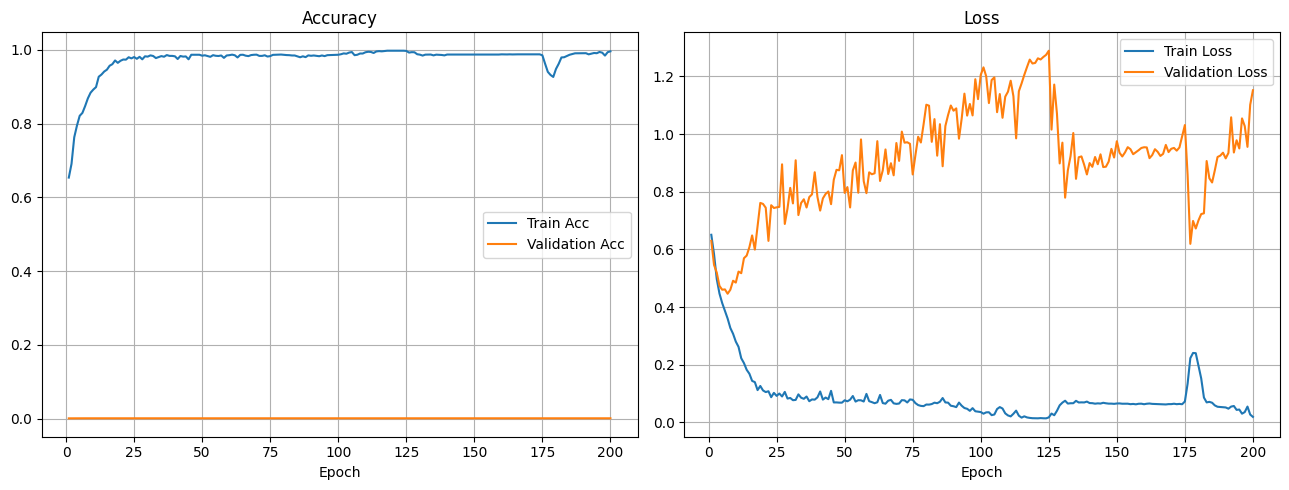

In [36]:
def genPlot(epoch_tr_loss, epoch_vl_loss, epoch_tr_acc, epoch_vl_acc):
  '''Generate plots of training and validation loss/accuracy.'''

  #Number of epochs.
  epochs = len(epoch_tr_loss)
  fig, axs = plt.subplots(1, 2, figsize=(13, 5))

  #Loss plot.
  axs[1].plot(range(1, epochs+1), epoch_tr_loss, label='Train Loss')
  axs[1].plot(range(1, epochs+1), epoch_vl_loss, label='Validation Loss')
  axs[1].set_title('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].legend()
  axs[1].grid(True)

  #Accuracy plot.
  axs[0].plot(range(1, epochs+1), epoch_tr_acc, label='Train Acc')
  axs[0].plot(range(1, epochs+1), epoch_vl_acc, label='Validation Acc')
  axs[0].set_title('Accuracy')
  axs[0].set_xlabel('Epoch')
  axs[0].legend()
  axs[0].grid(True)

  plt.tight_layout()
  plt.show()

genPlot(epoch_tr_loss, epoch_vl_loss, epoch_tr_acc, epoch_vl_acc)

## **(6) Prediction/Inference with the test set**

In [37]:
#Load weights from the saved best model.
model = MyLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
model.to(device)

model.load_state_dict(torch.load(best_model_path))
model.eval()  #Set the mode to eval (i.e., no gradient).

<ipython-input-37-21e17f7519d0>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


MyLSTM(
  (embeddings): Embedding(4922, 50, padding_idx=0)
  (lstm): LSTM(50, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (act): Sigmoid()
)

In [38]:
#----------------------------
# function to generate predictions for the testset
#----------------------------
def predict(model, test_list):
  '''Make prediction using test set.'''

  # (*) set the mode to evaluation
  model.eval()
  predictionList = []

  #Deactivate autograd.
  with torch.no_grad():
    for inputs in test_list:
      #Convert to a PyTorch tensor.
      inputs = torch.tensor(inputs).unsqueeze(0)
      inputs = inputs.to(device)
      #Feed forward.
      outputs = model(inputs)
      predictions = torch.round(outputs.squeeze())
      #Convert NumPy and append to predictionList.
      predictionList.append(predictions.cpu().numpy())

  return predictionList

In [39]:
##-------------------------------
## Inference/generate predictions
##-------------------------------
predictions = predict(model, x_test)

### **Write test predictions to a csv file (for Kaggle submission)**

In [40]:
#Submission requirement. Mae sure 1112 rows.
assert len(predictions) == 1112, f"Expected 1112 predictions, but got {len(predictions)}."
submissionData = pd.DataFrame({'index': range(len(predictions)),
                              'prediction': predictions})
#Write to csv file.
submissionData.to_csv('submission.csv', index=False)
print('Successfully saved!')

Successfully saved!


In [41]:
!jupyter nbconvert --to html "/content/drive/MyDrive/CSC583/CSC583 - Assignment 3.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/CSC583/CSC583 - Assignment 3.ipynb to html
[NbConvertApp] Writing 765258 bytes to /content/drive/MyDrive/CSC583/CSC583 - Assignment 3.html
